- `pip install fuzzywuzzy python-Levenshtein`

In [137]:
import os
from os import path,listdir
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import json 

import ipywidgets as widgets
from ipylab import JupyterFrontEnd
from IPython.display import display
from ipykernel.pylab.backend_inline import flush_figures

from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import MultiTaskLasso,RidgeClassifier,LogisticRegression
from sklearn.model_selection import KFold,cross_val_score,cross_validate
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score,  multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder
from fuzzywuzzy import process

pd.options.display.max_columns = 500
import warnings
warnings.filterwarnings("ignore")

def plot_confusion_matrices(y_test,y_pred,title='',pdf=None,hue_order=None,hue_map=None):
    sns.set_style('white')
    _labels = list(y_test.columns)
    cm = multilabel_confusion_matrix(y_test, y_pred)
    ncols = 4
    nrows = int(np.ceil(len(cm)/ncols))
    blank = (ncols*nrows)-len(cm)
    fig,axs =plt.subplots(figsize=(11,2.5*nrows),ncols=ncols,nrows=nrows)
    axs = axs.flatten()
    if hue_order is not None:
        iterlist = hue_order
    else:
        iterlist = list(range(len(cm)))
    for IDX,i in enumerate(iterlist):
        ax = axs[IDX]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[0,1])
        disp.plot(cmap='Blues',ax=ax)
        _title = _labels[i].replace('LABEL_','').replace('GROUP_','')
        if hue_map is not None:
            _title = hue_map.get(_title,_title.title())
        ax.set_title(f'{_title}',fontsize=10,fontweight='bold')
        if IDX%ncols!=0:
            ax.set_ylabel('')        
            ax.set_yticks([])
        if blank>0 and (IDX//ncols)==(nrows-2):
            if (ncols-(IDX%ncols))<=blank:
                continue
        if (IDX//ncols)!=(nrows-1):
            ax.set_xlabel('')        
            ax.set_xticks([])
    for i in range(len(cm),(ncols*nrows)):
        axs[i].axis('off')

    plt.suptitle(title,y=0.98,fontsize=14)
    # plt.subplots_adjust(wspace=0.15,hspace=0.32)
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def plot_pdp(dd,estimators,_X = 'ft_age',_Y = 'ft_bmi',title='',pdf=None):
    _X2,_Y2 = [map_all.get(x.replace('ft_',''),x.replace('ft_','').title()) for x in (_X,_Y)]
    _X2,_Y2 = [x+' (norm)' if (x.startswith('Age') or 
                               x.startswith('BMI') or 
                               x.startswith('Dur')) else x for x in (_X2,_Y2)]
    fig,axs = plt.subplots(figsize=(18.5,4),ncols=4)
    for idx,(name,E) in enumerate(estimators.items()):    
        ax = axs[idx]
        display = PartialDependenceDisplay.from_estimator(E, dd, [(_X, _Y)])
        display.plot(ax=ax, contour_kw={'cmap':'viridis'})
        display.axes_[0,0].set_xlabel(_X2)
        display.axes_[0,0].set_ylabel(_Y2)
        display.axes_[0,0].set_title(name)
    fig.suptitle(title,y=1.05)
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()  
    
map_all = {'staphylococci':'$\it{Staphylococcus}$ spp.',
         'enterobacterales':'Enterobacterales',
         'enteros':'Enterobacterales',
         'fungi':'Fungi',
          'enterococci':'$\it{Enterococcus}$ spp.',
          'streptococci':'$\it{Streptococcus}$ spp.',
          'gram.neg':'Other Gram-negative bacteria',
          'anaerobic':'Anaerobic bacteria',
           'age':'Age',
           'duree':'Duration of surgery',
           'bmi':'BMI [kg/m²]',
           'surg':'Type of surgery',
           'asa':'ASA score',
           'class':'Wound contamination',
           'clindamycine':'Clindamycine',
           'cephalosporin.all':'Cephalosporine',
           'glycopeptide':'Glycopeptide',
           'quinolone':'Quinolone',
           'elective':'Elective procedure',
           'endo_2L':'Minimally invasive procedure',
           'nitroimidazole':'Nitroimidazole',
           'penicillin.all':'Penicilin',
           'carbapenem':'Carbapenem',
           'SAP.b':'SAP administered (yes / no)',
           'hosp_size':'Hospital size',
           'sex':'Sex',
           'other.SAP2':'Other SAP',
           'prev.hosp.b':'Hospitalization prior to surgery'}
map_all_inv = {v:k for k,v in map_all.items()}

In [3]:
input_path = 'inputs'
output_path = 'outputs_september'
clean_train_csv = path.join(input_path,'scaled2.train.csv')
clean_test_csv = path.join(input_path,'scaled2.test.csv')

groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)
output_test_groups = path.join(output_path,'output_test_'+groups_name)

Full training: 5239
dropna training: 5239
Full test: 1363
dropna test: 1363
{'GROUP_anaerobic': ['LABEL_cutibacterium', 'LABEL_clostridium', 'LABEL_other.anaerobic', 'LABEL_bacteroides'], 'GROUP_enterobacterales': ['LABEL_e.coli', 'LABEL_klebsiella', 'LABEL_proteus', 'LABEL_serratia', 'LABEL_enterobacter', 'LABEL_other.enterobacteriacea'], 'GROUP_enterococci': ['LABEL_enterococci'], 'GROUP_fungi': ['LABEL_fungi'], 'GROUP_gram.neg': ['LABEL_pseudomonas', 'LABEL_other.gramneg'], 'GROUP_staphylococci': ['LABEL_staphylococci'], 'GROUP_streptococci': ['LABEL_streptococci']}
> Columns to keep: ['LABEL_bacteroides', 'LABEL_clostridium', 'LABEL_cutibacterium', 'LABEL_e.coli', 'LABEL_enterobacter', 'LABEL_enterococci', 'LABEL_fungi', 'LABEL_klebsiella', 'LABEL_other.anaerobic', 'LABEL_other.enterobacteriacea', 'LABEL_other.gramneg', 'LABEL_proteus', 'LABEL_pseudomonas', 'LABEL_serratia', 'LABEL_staphylococci', 'LABEL_streptococci']
> Columns to drop: {'LABEL_other.grampos', 'LABEL_other.bacteri

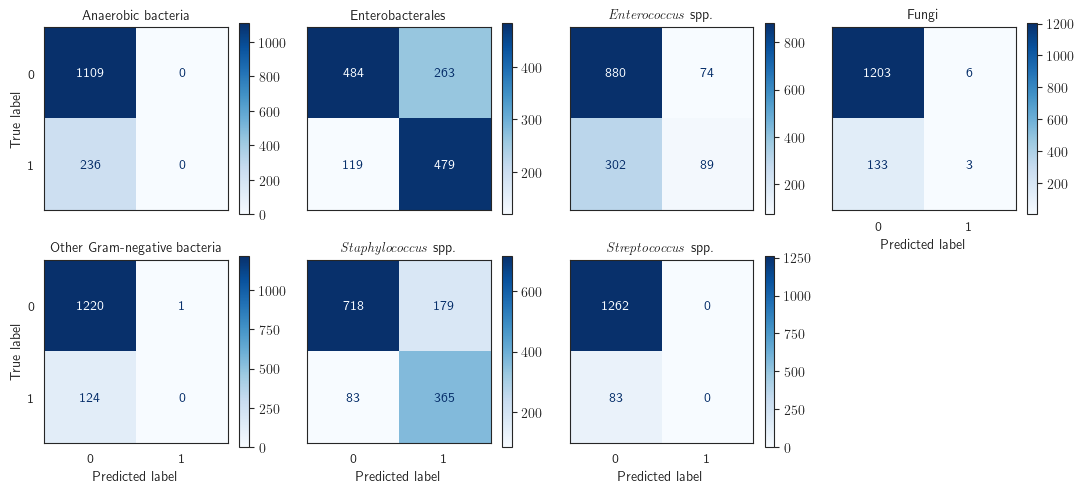

In [164]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'HelveticaOblique'

pdf = None

groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)    
df = pd.read_csv(clean_train_csv)    
dfT = pd.read_csv(clean_test_csv)
df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))

df = df[[x for x in df.columns if not x.startswith('ft_surg_')]]
dfT = dfT[[x for x in dfT.columns if not x.startswith('ft_surg_')]]

cols_ft = [x for x in df.columns if x.startswith('ft_')]
cols_labels = sorted([x for x in df.columns if x.startswith('LABEL_')])
cols_labels_full = list(cols_labels)

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

### Load groups
groups = {}
for g,d in pd.read_csv(groups_csv,sep=';').groupby('group'):
    groups['GROUP_'+g] = ['LABEL_'+x for x in d.bacteria]
print(groups)
present_labels = set(sum(list(groups.values()),[]))
all_labels = set(cols_labels)
cols_labels = sorted(present_labels)
print('> Columns to keep:',cols_labels)
print('> Columns to drop:', all_labels-present_labels)
for k,v in groups.items():
    df[k] = (df[v].sum(axis=1)>0).astype(int)
    dfT[k] = (dfT[v].sum(axis=1)>0).astype(int)
cols_groups = sorted([x for x in df.columns if x.startswith('GROUP_')])
df.drop(columns = all_labels-present_labels,inplace=True)
dfT.drop(columns = all_labels-present_labels,inplace=True)

###### Assign groups
df = df[df[cols_groups].sum(axis=1)>0]
dfT = dfT[dfT[cols_groups].sum(axis=1)>0]
print('After groups training:',len(df))
print('After groups test:',len(dfT))
    
X_train = df[cols_ft]
y_total = df[cols_labels]
y_groups = df[cols_groups]
X_test = dfT[cols_ft]
y_test_total = dfT[cols_labels]
y_test_groups = dfT[cols_groups]

HIGH_VIF = []
X_train2 = X_train.drop(columns=HIGH_VIF)
X_test2 = X_test.drop(columns=HIGH_VIF)

#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

features = list(X_train.columns)
labels_groups = list(y_groups.columns)
labels_total = list(y_total.columns)

# model = RidgeClassifier(alpha=1,random_state=42)
# model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
model = AdaBoostClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
# model = GaussianNB()
total_classifier = MultiOutputClassifier(model).fit(X_train2, y_total)
group_classifier = MultiOutputClassifier(model).fit(X_train2, y_groups)

# #####################
R_group = {}
R_bacteria = {}
group = groups_name.split('.')[0]

y_total_pred = total_classifier.predict(X_test2)
y_groups_pred = group_classifier.predict(X_test2)

accuracy = accuracy_score(y_test_groups, y_groups_pred)
precision = precision_score(y_test_groups, y_groups_pred, average='micro')
recall = recall_score(y_test_groups, y_groups_pred, average='micro')
f1 = f1_score(y_test_groups, y_groups_pred, average='micro')
R_group[namex] = {'accuracy':accuracy,
           'precision_micro':precision, 
           'recall_micro':recall, 
           'f1_micro':f1}

accuracy = accuracy_score(y_test_total, y_total_pred)
precision = precision_score(y_test_total, y_total_pred, average='micro')
recall = recall_score(y_test_total, y_total_pred, average='micro')
f1 = f1_score(y_test_total, y_total_pred, average='micro')
R_bacteria[namex] = {'accuracy':accuracy,
           'precision_micro':precision, 
           'recall_micro':recall, 
           'f1_micro':f1}
print('Groups',R_group)
print('Bacteria',R_bacteria)

plot_confusion_matrices(y_test_groups,y_groups_pred,title='',pdf=None,hue_order=None,hue_map=map_all)

# plot

In [165]:
X_train2.columns
y_groups.columns
group_classifier.estimators_
estimators = { map_all.get(col_name.replace('GROUP_',''),col_name.replace('GROUP_','').title()) : estimator 
                           for col_name, estimator in zip(y_groups.columns, group_classifier.estimators_)}
estimators.pop('Anaerobic bacteria')
estimators.pop('Fungi')
estimators.pop('Other Gram-negative bacteria')
X_train2.columns

Index(['ft_age', 'ft_bmi', 'ft_duree', 'ft_asa_1', 'ft_asa_2', 'ft_asa_3',
       'ft_asa_4', 'ft_asa_5', 'ft_class_Clean', 'ft_class_Clean-Contaminated',
       'ft_class_Contaminated', 'ft_class_Dirty/Infected',
       'ft_hosp_size_200-499', 'ft_hosp_size_500+', 'ft_hosp_size_<200',
       'ft_carbapenem', 'ft_cephalosporin.all', 'ft_clindamycine',
       'ft_elective', 'ft_endo_2L', 'ft_glycopeptide', 'ft_implant',
       'ft_nitroimidazole', 'ft_other.SAP2', 'ft_penicillin.all',
       'ft_prev.hosp.b', 'ft_quinolone', 'ft_SAP.b', 'ft_scoreT', 'ft_sex'],
      dtype='object')

In [166]:
# z = pd.read_csv('inputs/List_SAP.txt',header=None,sep='\t')
z = pd.read_csv('inputs/List_SAP_v2.txt',header=None,sep='\t')
B = [x.split(',') for x in z[0]]

cols_ft = list(X_train2.columns)
dfx = pd.read_csv(clean_train_csv)
dfx['_id'] = range(len(dfx))
A = list(dfx.columns)

# Initialize the result list
query = []
# Iterate over each list in B
for b_list in B:
    # Initialize a list to hold the closest elements for the current b_list
    closest_elements = []
    for word in b_list:
        # Find the closest element in A for each word in b_list
        closest_element, _ = process.extractOne('ft_'+word, A)
        closest_elements.append(closest_element)
    # Append the tuple (b_list, closest_elements) to the result
    query.append((b_list, closest_elements))
for q in query:
    print(q)

(['Cephalosporine', 'Nitroimidazole'], ['ft_cephalosporin.all', 'ft_nitroimidazole'])
(['Cephalosporine'], ['ft_cephalosporin.all'])
(['Glycopeptide'], ['ft_glycopeptide'])


In [ ]:
# output_pdf = 'outputs_september/PDP_naivebayes.pdf'
output_pdf = 'outputs_september/PDP_adaboost.pdf'
# output_pdf = 'outputs_september/PDP_randomforest.pdf'
pdf = PdfPages(output_pdf)

dd = dfx
dd = dd[cols_ft]
plot_pdp(dd,estimators,_X = 'ft_age',_Y = 'ft_bmi',title='All surgeries',pdf=pdf)

for q in query:
    print(q)
    dd = dfx
    print(len(dd))
    for x in q[1]:
        dd = dd[dd[x]==1]
    print(len(dd))
    dd = dd[cols_ft]
    title = '; '.join(["%s=1"%x for x in q[0]])+' $(n=%d)$'%len(dd)
    plot_pdp(dd,estimators,_X = 'ft_age',_Y = 'ft_bmi',title=title,pdf=pdf)
    # break
pdf.close()

In [ ]:
# output_pdf = 'outputs_september/PDP_naivebayes.pdf'
output_pdf = 'outputs_september/PDP_adaboost.pdf'
# output_pdf = 'outputs_september/PDP_randomforest.pdf'
pdf = PdfPages(output_pdf)

dd = dfx
dd = dd[cols_ft]
plot_pdp(dd,estimators,_X = 'ft_age',_Y = 'ft_bmi',title='All surgeries',pdf=pdf)

for q in query:
    print(q)
    dd = dfx
    print(len(dd))
    for x in q[1]:
        dd = dd[dd[x]==1]
    print(len(dd))
    dd = dd[cols_ft]
    title = '; '.join(["%s=1"%x for x in q[0]])+' $(n=%d)$'%len(dd)
    plot_pdp(dd,estimators,_X = 'ft_age',_Y = 'ft_bmi',title=title,pdf=pdf)
    # break
pdf.close()

In [158]:
pdf.close()
plt.close('all')